In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
os.listdir('data/')

['exisiting_EV_infrastructure_2018.csv',
 'Demand_History.csv',
 'sample_submission.csv']

In [3]:
df=pd.read_csv('data/Demand_History.csv')
df1=pd.read_csv('data/exisiting_EV_infrastructure_2018.csv')
df2=pd.read_csv('data/sample_submission.csv')

In [4]:
df.head()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563


In [5]:
df1.head()

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS
0,0,50.163110,19.412014,23,5,3
1,1,37.336451,58.119225,27,4,7
2,2,46.709232,57.525650,31,6,14
3,3,30.528626,55.379835,26,5,5
4,4,51.521781,35.116755,32,11,6


In [161]:
# Sample Submission
df2.sample(3, random_state=0)

,year,data_type,demand_point_index,supply_point_index,value
67455,2019,DS,672.0,55,0.000000
69544,2019,DS,693.0,44,0.001301
35032,2019,DS,348.0,32,0.000000


In [7]:
sales_cols = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [8]:
df['total_sales'] = df[sales_cols].sum(axis=1)

In [9]:
df1['supply_point_index'].nunique()

100

In [10]:
k = df.sort_values(by='total_sales', ascending=False).head(100)

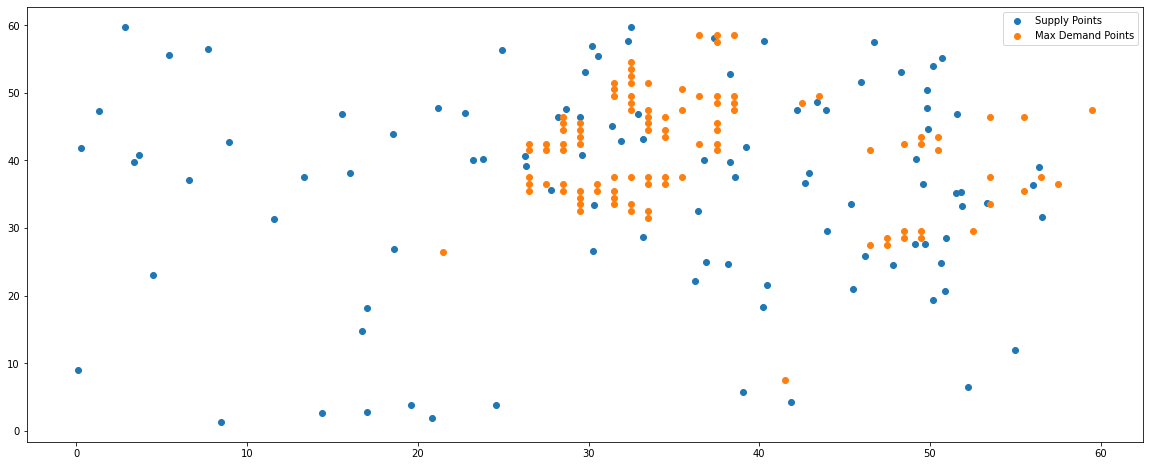

In [11]:
plt.scatter(df1['x_coordinate'], df1['y_coordinate'])
plt.scatter(k['x_coordinate'], k['y_coordinate'])
plt.legend(['Supply Points', 'Max Demand Points'])

In [138]:
df.drop(columns='total_sales', inplace=True)

In [139]:
df.head()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,19.142751,26.684036
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,17.589242,25.759327
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,20.705914,27.705796
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,22.441263,29.175547
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,23.358258,29.718429


# Forecasting

In [140]:
import numpy as np
from lightgbm import LGBMRegressor

In [141]:
model = LGBMRegressor()

### __Create features__

In [142]:
df['2019'] = np.nan
df['2020'] = np.nan
sales_cols = ['2010', '2011', '2012', '2013', '2014', 
              '2015', '2016', '2017', '2018', '2019', '2020']

In [143]:
dem = df.melt(id_vars='demand_point_index', value_vars=sales_cols, value_name='demand')
dem = dem.sort_values(by=['demand_point_index','variable']).reset_index(drop=True)
dem.head()

,demand_point_index,variable,demand
0,0,2010,0.352242
1,0,2011,0.667932
2,0,2012,0.958593
3,0,2013,2.911901
4,0,2014,4.338274


In [144]:
dem.fillna(0, inplace=True)

In [145]:
dem['prev_value_1'] = dem.groupby('demand_point_index')['demand'].shift()
dem['prev_value_2'] = dem.groupby('demand_point_index')['demand'].shift(2)
dem['prev_value_3'] = dem.groupby('demand_point_index')['demand'].shift(3)

In [146]:
# dem['diff_1'] = dem['demand'] - dem['prev_value_1']
# dem['diff_2'] = dem['demand'] - dem['prev_value_2']
# dem['diff_3'] = dem['demand'] - dem['prev_value_3']

In [147]:
dem.fillna(0, inplace=True)

In [148]:
features = ['prev_value_1', 'prev_value_2', 'prev_value_3']
target = 'demand'

In [149]:
dem.head()

,demand_point_index,variable,demand,prev_value_1,prev_value_2,prev_value_3
0,0,2010,0.352242,0.000000,0.000000,0.000000
1,0,2011,0.667932,0.352242,0.000000,0.000000
2,0,2012,0.958593,0.667932,0.352242,0.000000
3,0,2013,2.911901,0.958593,0.667932,0.352242
4,0,2014,4.338274,2.911901,0.958593,0.667932


In [152]:
train = dem[~dem['variable'].isin(['2019', '2020'])].reset_index(drop=True)
test1 = dem[dem['variable'].isin(['2019'])].reset_index(drop=True)
test2 = dem[dem['variable'].isin(['2020'])].reset_index(drop=True)

In [153]:
model.fit(train[features],train[target])

LGBMRegressor()

In [154]:
df['2019'] = model.predict(test1[features])

In [155]:
test2['prev_value_1'] = df['2019']

In [156]:
df['2020'] = model.predict(test2[features])

In [158]:
df.sample(5, random_state=42)

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1299,1299,19.5,20.5,3.617461,7.661451,14.284976,33.290032,53.633337,99.385764,129.952637,175.331675,156.337300,200.542364,225.433269
1338,1338,58.5,20.5,0.065269,0.143924,0.209855,0.883347,1.230552,1.776625,2.671072,2.713626,3.395218,4.268329,5.843489
3873,3873,33.5,60.5,0.210314,0.604396,1.061072,2.630263,4.298965,5.229857,6.592096,12.363441,11.975485,18.092299,26.428268
2083,2083,35.5,32.5,2.937517,4.244179,7.768899,31.594318,49.086031,87.123299,119.269294,143.099275,152.401201,190.589613,219.189962
1498,1498,26.5,23.5,1.110802,1.965516,4.547065,13.072819,30.306850,50.169391,76.749221,81.998267,108.234956,152.797547,194.863484


# Optimization

### __Creating Distance Matrix__

In [167]:
demand_cords=['demand_point_index','x_coordinate','y_coordinate']
supply_cords=['supply_point_index','x_coordinate','y_coordinate']

In [185]:
k1 = df[['x_coordinate','y_coordinate']].values
df[demand_cords].head()

,demand_point_index,x_coordinate,y_coordinate
0,0,0.5,0.5
1,1,1.5,0.5
2,2,2.5,0.5
3,3,3.5,0.5
4,4,4.5,0.5


In [186]:
k2 = df1[['x_coordinate','y_coordinate']].values
df1[supply_cords].head()

,supply_point_index,x_coordinate,y_coordinate
0,0,50.163110,19.412014
1,1,37.336451,58.119225
2,2,46.709232,57.525650
3,3,30.528626,55.379835
4,4,51.521781,35.116755


In [171]:
from itertools import product

In [196]:
from tqdm import tqdm

In [207]:
def create_distance_matrix(k1, k2):
    dist = []
    for i,j in tqdm(list(product(k1, k2))):
        dist.append(np.linalg.norm(i - j))

    index = list(product(df['demand_point_index'], df1['supply_point_index']))
    dist_df = pd.DataFrame(index, columns=['demand_point_index', 'supply_point_index'])
    dist_df['distance']=dist
    return dist_df

In [208]:
dist_df = create_distance_matrix(k1, k2)

100%|██████████| 409600/409600 [00:02<00:00, 190735.14it/s]


In [209]:
dist_df.sample(5, random_state=42)

,demand_point_index,supply_point_index,distance
186728,1867,28,17.680810
289545,2895,45,21.901613
93665,936,65,24.655897
312160,3121,60,54.770851
49990,499,90,36.124187


In [748]:
dist = dist_df.set_index(['demand_point_index', 'supply_point_index']).to_dict()['distance']

In [705]:
dist_keys = [(2018, i, j) for i,j in dist.keys()] + [(2019, i, j) for i,j in dist.keys()]  + [(2020, i, j) for i,j in dist.keys()]

In [707]:
len(dist_keys)

1228800

In [708]:
# dist = dist_df.pivot_table(values='distance', index='demand_point_index', columns='supply_point_index').values

### __Creating Smax, indexes, constants__

In [886]:
cap_scs = 199
cap_fcs = 399

In [887]:
demand_point = df['demand_point_index'].tolist()
supply_point = df1['supply_point_index'].tolist()

In [851]:
r=1.5

In [852]:
PS = (df1[['supply_point_index', 'total_parking_slots']].set_index('supply_point_index')).to_dict()['total_parking_slots']

In [853]:
# For 2019
existing_num_SCS = df1[['supply_point_index','existing_num_SCS']].set_index('supply_point_index').to_dict()['existing_num_SCS']
existing_num_FCS = df1[['supply_point_index','existing_num_FCS']].set_index('supply_point_index').to_dict()['existing_num_FCS']

In [854]:
# supply_point_fin = list(product([2018, 2019, 2020], supply_point))

In [855]:
# d1=dict([((2018, int(i[0][0])), i[0][1]) for i in zip(df[['demand_point_index','2018']].values)])
# d2=dict([((2019, int(i[0][0])), i[0][1]) for i in zip(df[['demand_point_index','2019']].values)])
# d3=dict([((2020, int(i[0][0])), i[0][1]) for i in zip(df[['demand_point_index','2020']].values)])

In [856]:
# d1.update(d2)
# d1.update(d3)
# d_forecast = d1
d_forecast = df[['demand_point_index','2019']].set_index('demand_point_index').to_dict()['2019']

# __PuLP Model__

In [857]:
from pulp import *

In [858]:
prob = LpProblem("EV_Problem", LpMinimize)

__Define DVars__

In [859]:
DS = LpVariable.dicts(name="demand_supply_match", lowBound=0, upBound=None, indices=(list(dist.keys())),  cat='Continuous')
SCS = LpVariable.dicts("scs", lowBound=0, upBound=None, indices=supply_point, cat=LpInteger)
FCS = LpVariable.dicts("fcs", lowBound=0, upBound=None, indices=supply_point, cat=LpInteger)

__Define Objective__

In [860]:
prob += (
    lpSum([(dist[(i,j)] * DS[(i,j)]) for i in demand_point for j in supply_point]) + 600*lpSum([(SCS[j] + (r* FCS[j])) for j in supply_point]),
    "Cost of Customer Dissatisfaction"
)


### __Define Constraints__

__C1__

In [861]:
for i in demand_point:
    for j in supply_point:
        prob += DS[(i,j)] >= 0

__C2__

In [862]:
for j in supply_point:
    prob += (SCS[j]) >= 0

In [863]:
for j in supply_point:
    prob += FCS[j] >= 0

__C3__

In [864]:
for j in supply_point:
    prob += SCS[j] + FCS[j] <= PS[j]

__C4__

In [865]:
for j in supply_point:
    prob += SCS[j] >= existing_num_SCS[j]
    prob += FCS[j] >= existing_num_FCS[j]

__C5__

In [866]:
for j in supply_point:
    prob += ([DS[(i,j)] for i in demand_point]) <= (cap_scs*SCS[j]) + (cap_fcs*FCS[j])

__C6__

In [867]:
for i in demand_point:
    prob += lpSum([DS[(i,j)] for j in supply_point]) == d_forecast[i]

__Solve__

In [868]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /libraries/gpu-env-2022/lib/python3.7/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/fbc27e256fc446d1a87fd6d60da85830-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/fbc27e256fc446d1a87fd6d60da85830-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 414301 COLUMNS
At line 2054102 RHS
At line 2468399 BOUNDS
At line 2468600 ENDATA
Problem MODEL has 414296 rows, 409800 columns and 1229600 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.70568e+06 - 1.17 seconds
Cgl0004I processed model has 4296 rows, 409800 columns (200 integer (0 of which binary)) and 819600 elements
Cbc0012I Integer solution of 2705792.2 found by DiveCoefficient after 0 iterations and 0 nodes (7.30 seconds)
Cbc0038I Full problem 4296 rows 409800 columns, reduced to 4196 rows 409617 columns - too 

1

In [944]:
k = []
for v in prob.variables():
    if v.varValue>=0:
        k.append((v.name, "=", v.varValue))

In [945]:
len(k)

409800

In [946]:
import re

In [947]:
ds_lst = []
for j,i in tqdm(enumerate(k)):
    if i[0].startswith('demand_supply_match'):
        ds_lst.append((tuple(re.sub('[_ )]','', re.findall('[0-9].*',i[0])[0]).split(',')), i[2]))

409800it [00:01, 245040.53it/s]


In [948]:
ds_df = pd.DataFrame(ds_lst, columns=['0', 'value'])
ds_df['demand_point_index'], ds_df['supply_point_index'] = zip(*ds_df['0'])
ds_df.drop(columns='0', inplace=True)
ds_df['year'] = 2019
ds_df['data_type'] = 'DS'

In [949]:
ds_df

,value,demand_point_index,supply_point_index,year,data_type
0,0.0,0,0,2019,DS
1,0.0,0,1,2019,DS
2,0.0,0,10,2019,DS
3,0.0,0,11,2019,DS
4,0.0,0,12,2019,DS
...,...,...,...,...,...
409595,0.0,999,95,2019,DS
409596,0.0,999,96,2019,DS
409597,0.0,999,97,2019,DS
409598,0.0,999,98,2019,DS


In [950]:
fcs_lst = []
for j,i in enumerate(k):
    if i[0].startswith('fcs'):
        fcs_lst.append((int(i[0].split('_')[1]), i[2]))

In [951]:
scs_lst = []
for j,i in enumerate(k):
    if i[0].startswith('scs'):
        scs_lst.append((int(i[0].split('_')[1]), i[2]))

In [952]:
fcs = pd.DataFrame(fcs_lst, columns=['supply_point_index', 'value'])
fcs['year'] = 2019
fcs['data_type'] = 'FCS'
scs = pd.DataFrame(scs_lst, columns=['supply_point_index', 'value'])
scs['year'] = 2019
scs['data_type'] = 'SCS'

__Export Result__

In [953]:
df3 = pd.concat([scs, fcs, ds_df])
df3['supply_point_index'] = df3['supply_point_index'].astype(int)
df3['demand_point_index'] = df3['demand_point_index'].astype(float)


In [954]:
df3['value'] = np.floor(df3['value'])

In [955]:
# temp = pd.DataFrame({'supply_point_index':[61],'value':[0], 'year':[2019], 'data_type':['FCS'], 'demand_point_index':[np.nan]})
# df3 = pd.concat([df3,temp]).reset_index(drop=True)

In [956]:
df3.to_csv('res_3.csv', index=False)

### __Validation__

__Constraint 5__

In [937]:
calc= df3[df3['data_type']=='DS'].groupby('supply_point_index')['value'].sum()

In [938]:
df3['power'] = 0
df3.loc[df3['data_type']=='SCS', 'power'] = 200
df3.loc[df3['data_type']=='FCS', 'power'] = 400

In [939]:
smax = df3[(~df3['data_type'].isin(['DS']))].groupby('supply_point_index').apply(lambda x: x['value']*x['power']).reset_index().groupby('supply_point_index')[0].sum()

In [940]:
z = pd.DataFrame([smax, calc]).T.reset_index()
z

,supply_point_index,0,value
0,0,8200.0,8150.0
1,1,3600.0,3584.0
2,2,6800.0,3340.0
3,3,3000.0,2994.0
4,4,4600.0,573.0
...,...,...,...
95,95,6600.0,6573.0
96,96,9400.0,9379.0
97,97,12000.0,11942.0
98,98,3400.0,3390.0


In [941]:
z[z[0]<z['value']]

,supply_point_index,0,value


In [943]:
df3[df3['supply_point_index']==61]

,supply_point_index,value,year,data_type,demand_point_index,power
58,61,3.0,2019,SCS,NaN,200
3063,61,1.0,2019,DS,3520.0,0
3133,61,2.0,2019,DS,3584.0,0
3134,61,1.0,2019,DS,3585.0,0
3205,61,2.0,2019,DS,3648.0,0
3206,61,1.0,2019,DS,3649.0,0
3208,61,1.0,2019,DS,3650.0,0
3209,61,1.0,2019,DS,3651.0,0
3277,61,1.0,2019,DS,3712.0,0
3278,61,1.0,2019,DS,3713.0,0


__Constraint 4__

In [907]:
k = df3[~df3['data_type'].isin(['DS'])].groupby(['data_type', 'supply_point_index'])['value'].sum().reset_index()
k

,data_type,supply_point_index,value
0,FCS,0,18.0
1,FCS,1,7.0
2,FCS,2,14.0
3,FCS,3,5.0
4,FCS,4,6.0
...,...,...,...
194,SCS,95,3.0
195,SCS,96,5.0
196,SCS,97,4.0
197,SCS,98,7.0


In [908]:
k[k['data_type']=='FCS']['value'].sum()

885.0

In [909]:
df5 = df1.merge(k, on=['supply_point_index'], how='left')
df5

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS,data_type,value
0,0,50.163110,19.412014,23,5,3,FCS,18.0
1,0,50.163110,19.412014,23,5,3,SCS,5.0
2,1,37.336451,58.119225,27,4,7,FCS,7.0
3,1,37.336451,58.119225,27,4,7,SCS,4.0
4,2,46.709232,57.525650,31,6,14,FCS,14.0
...,...,...,...,...,...,...,...,...
194,97,36.218839,22.235766,32,4,14,SCS,4.0
195,98,42.936915,38.122442,28,7,5,FCS,5.0
196,98,42.936915,38.122442,28,7,5,SCS,7.0
197,99,19.590263,3.830284,24,2,11,FCS,11.0


In [910]:
z = pd.DataFrame([k[k['data_type']=='SCS'].groupby('supply_point_index')['value'].sum(),df1.groupby('supply_point_index')['existing_num_SCS'].sum()]).T
z[z['existing_num_SCS']>z['value']]

,value,existing_num_SCS
supply_point_index,,


In [911]:
z = pd.DataFrame([k[k['data_type']=='FCS'].groupby('supply_point_index')['value'].sum(),df1.groupby('supply_point_index')['existing_num_FCS'].sum()]).T
z[z['existing_num_FCS']>z['value']]

,value,existing_num_FCS
supply_point_index,,


In [912]:
z

,value,existing_num_FCS
supply_point_index,,
0,18.0,3.0
1,7.0,7.0
2,14.0,14.0
3,5.0,5.0
4,6.0,6.0
...,...,...
95,15.0,4.0
96,21.0,10.0
97,28.0,14.0


In [929]:
df1

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS
0,0,50.163110,19.412014,23,5,3
1,1,37.336451,58.119225,27,4,7
2,2,46.709232,57.525650,31,6,14
3,3,30.528626,55.379835,26,5,5
4,4,51.521781,35.116755,32,11,6
...,...,...,...,...,...,...
95,95,45.471204,20.999414,24,3,4
96,96,30.318396,33.388335,32,5,10
97,97,36.218839,22.235766,32,4,14
98,98,42.936915,38.122442,28,7,5


In [914]:
z

,value,existing_num_FCS
supply_point_index,,
0,18.0,3.0
1,7.0,7.0
2,14.0,14.0
3,5.0,5.0
4,6.0,6.0
...,...,...
95,15.0,4.0
96,21.0,10.0
97,28.0,14.0


In [915]:
k = df3[~df3['data_type'].isin(['DS'])].groupby(['data_type', 'supply_point_index'])['value'].sum().reset_index()
k

,data_type,supply_point_index,value
0,FCS,0,18.0
1,FCS,1,7.0
2,FCS,2,14.0
3,FCS,3,5.0
4,FCS,4,6.0
...,...,...,...
194,SCS,95,3.0
195,SCS,96,5.0
196,SCS,97,4.0
197,SCS,98,7.0


In [918]:
z = pd.DataFrame([k[k['data_type']=='FCS'].groupby('supply_point_index')['value'].sum(),df1.groupby('supply_point_index')['existing_num_FCS'].sum()]).T.reset_index()
z[z['existing_num_FCS']>z['value']]

,supply_point_index,value,existing_num_FCS


In [919]:
z = pd.DataFrame([k[k['data_type']=='SCS'].groupby('supply_point_index')['value'].sum(),df1.groupby('supply_point_index')['existing_num_SCS'].sum()]).T.reset_index()
z[z['existing_num_SCS']>z['value']]

,supply_point_index,value,existing_num_SCS


In [928]:
set(df2[df2['data_type']=='FCS']['supply_point_index'].unique()) - set(df3[df3['data_type']=='FCS']['supply_point_index'].unique())

{61}

In [930]:
df1[df1['supply_point_index']==61]

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS
61,61,2.848186,59.787741,11,3,0


,supply_point_index,value,year,data_type,demand_point_index,power
0,0,5.0,2019,SCS,NaN,200.0
1,1,4.0,2019,SCS,NaN,200.0
2,10,6.0,2019,SCS,NaN,200.0
3,11,9.0,2019,SCS,NaN,200.0
4,12,5.0,2019,SCS,NaN,200.0
...,...,...,...,...,...,...
4168,69,171.0,2019,DS,996.0,0.0
4169,69,210.0,2019,DS,997.0,0.0
4170,69,119.0,2019,DS,998.0,0.0
4171,69,72.0,2019,DS,999.0,0.0


In [931]:
df3

,supply_point_index,value,year,data_type,demand_point_index,power
0,0,5.0,2019,SCS,NaN,200
1,1,4.0,2019,SCS,NaN,200
2,10,6.0,2019,SCS,NaN,200
3,11,9.0,2019,SCS,NaN,200
4,12,5.0,2019,SCS,NaN,200
...,...,...,...,...,...,...
4167,97,181.0,2019,DS,995.0,0
4168,69,171.0,2019,DS,996.0,0
4169,69,210.0,2019,DS,997.0,0
4170,69,119.0,2019,DS,998.0,0
